# Projeto C318

O projeto tem como intuito fazer uma anásile de um dataset fornecido neste link do [Kaggle](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database?resource=download&select=diabetes.csv).  
No qual, se trata de um dataset que contém alguns dados médicos, em particular, de mulheres com pelo menos 21 anos e de ascendência indígena Pima.  
Cujo o intuito é criar um modelo de ML, capaz de prever se o paciente tem ou não diabetes.

## Importação de Bibliotecas

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Análise dos dados

In [3]:
df = pd.read_csv('diabetes.csv')

In [8]:
print(f"Este dataset contém os dados clínicos de {len(df)} pacientes")
print(f"Features: {df.columns.to_list()[:-1]}")
print(f"Target: {df.columns.to_list()[-1]}")
print(f"Existe valores faltantes? {df.isna().any().any()}")

Este dataset contém os dados clínicos de 768 pacientes
Features: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Target: Outcome
Existe valores faltantes? False


### Análise da Variável Target

A variável target é qualitativa(categórica), logo estamos trabalhando com um modelo de classificação.  
Na figura abaixo podemos analisar a quantidade de pacientes com(1) e sem(0) diabetes.  
É possível notar que o dataset se encontra desbalanceado.

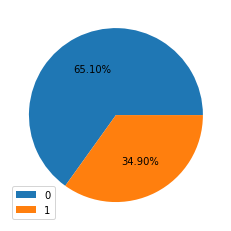

In [7]:
plt.pie(df['Outcome'].value_counts().to_list(), autopct='%.02f%%')
plt.legend(['0', '1'])
plt.show()

### Análise das Features

#### Pregnancies

Representa o número de vezes que aquela paciente ficou grávida.  
Como podemos analisar abaixo, este valor varia entre 0 e 17.  
Neste gráfico podemos analisar a proporção de pacientes com e sem diabetes, levando em consideração o número de gestações.  
Uma curiosidade é que cerca de 140 pacientes, tiveram apenas 1 filho(a). E aproximadamente 30 delas apresentaram diabetes.

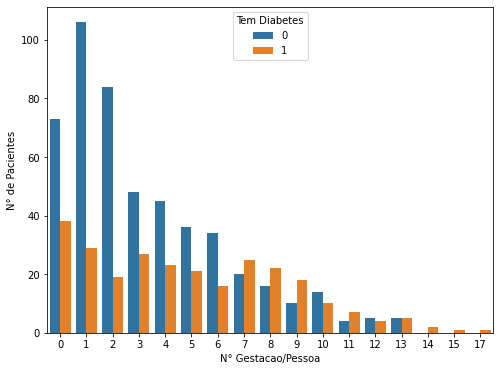

In [75]:
aux = df[['Pregnancies','Outcome']].value_counts().sort_index().reset_index()
aux.columns = ['N° Gestacao/Pessoa', 'Tem Diabetes', 'N° de Pacientes']
plt.figure(figsize=(8, 6))
sns.barplot(aux, x='N° Gestacao/Pessoa', y='N° de Pacientes', hue='Tem Diabetes')
plt.show()

#### Glucose

Esta feature representa a "Concentração de glicose plasmática a 2 horas em um teste oral de tolerância à glicose".  
Neste teste é administrado uma quantidade X de glicose no paciente e após 2 horas é medido o valor de glicemia.  
Valores entre 140 e 200 mg/dL é considerado pré-diabetes e acima de 200mg/dL confirma o diagnóstico de diabetes.  
No gráfico abaixo, podemos observar tal feito, o número de casos sem diabetes com valores acima de 150mg/dL diminui considerávelmente.

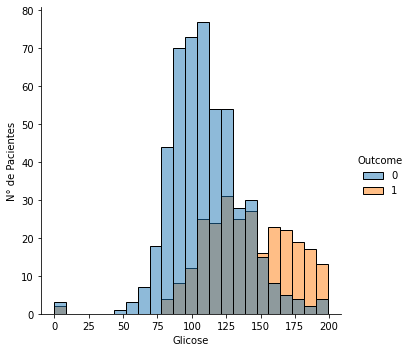

In [35]:
ax = sns.displot(df, x="Glucose", hue='Outcome')
plt.xlabel("Glicose")
plt.ylabel('N° de Pacientes')
plt.show()

#### BloodPressure

Pressão arterial diastólica (mmHg)

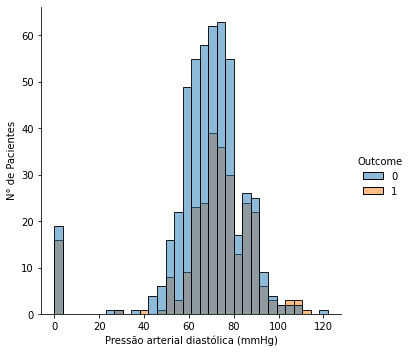

In [31]:
sns.displot(df, x="BloodPressure", hue='Outcome')
plt.xlabel("Pressão arterial diastólica (mmHg)")
plt.ylabel('N° de Pacientes')
plt.show()

#### SkinThickness

Espessura da dobra cutânea do tríceps (mm)

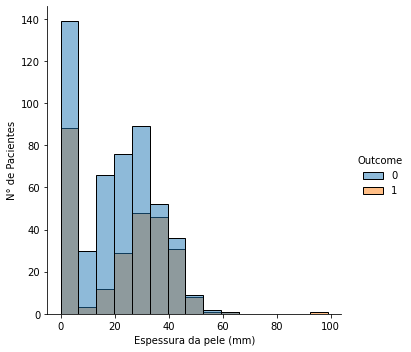

In [37]:
sns.displot(df, x="SkinThickness", hue='Outcome')
plt.xlabel("Espessura da pele (mm)")
plt.ylabel('N° de Pacientes')
plt.show()

#### Insulin

Representa a "Insulina sérica de 2 horas (mu U/ml)".

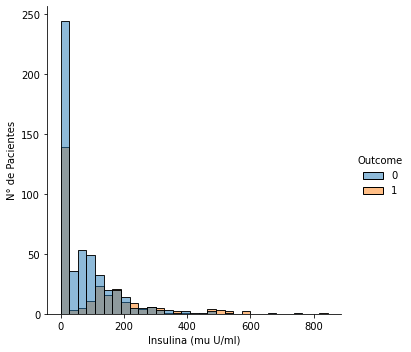

In [7]:
sns.displot(df, x="Insulin", hue='Outcome')
plt.xlabel("Insulina (mu U/ml)")
plt.ylabel('N° de Pacientes')
plt.show()

#### BMI

Índice de massa corporal (peso em kg/(altura em m)^2)

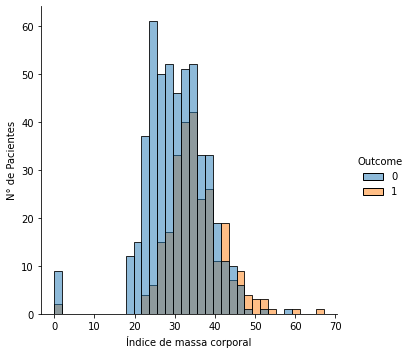

In [11]:
sns.displot(df, x="BMI", hue='Outcome')
plt.xlabel("Índice de massa corporal")
plt.ylabel('N° de Pacientes')
plt.show()

#### DiabetesPedigreeFunction

Função hereditária do diabetes

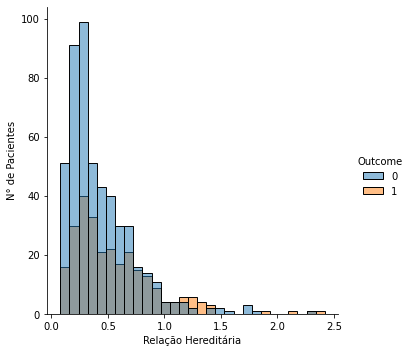

In [13]:
sns.displot(df, x="DiabetesPedigreeFunction", hue='Outcome')
plt.xlabel("Relação Hereditária")
plt.ylabel('N° de Pacientes')
plt.show()

#### Age

Idade dos pacientes.

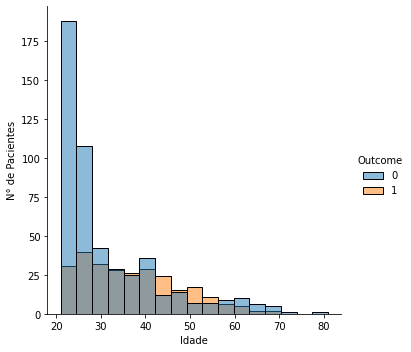

In [14]:
sns.displot(df, x="Age", hue='Outcome')
plt.xlabel("Idade")
plt.ylabel('N° de Pacientes')
plt.show()

#### gráfico geral

Matriz de correlação das variáveis:
AxesSubplot(0.125,0.125;0.62x0.755)


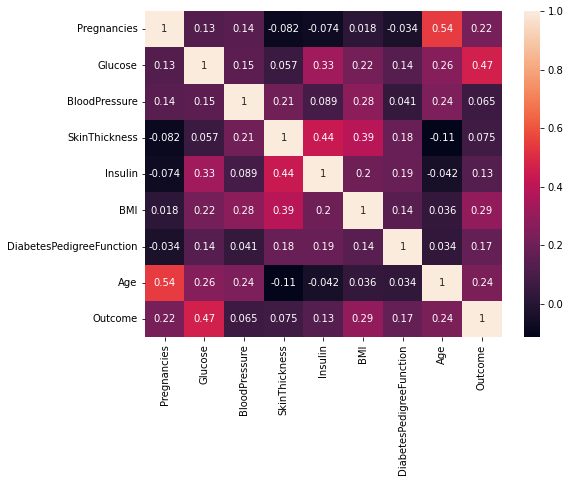

In [26]:
plt.figure(figsize=(8, 6))
print(f"Matriz de correlação das variáveis:\n{sns.heatmap(df.corr(), annot=True)}")
plt.show()